In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns
import csvWOD
import copy

# switch to unbuffered output
class Unbuffered(object):
    def __init__(self, stream):
        self.stream = stream
    def write(self, data):
        self.stream.write(data)
        self.stream.flush()
    def __getattr__(self, attr):
        return getattr(self.stream, attr)

import sys
sys.stdout = Unbuffered(sys.stdout)

sns.set()

%matplotlib inline

In [2]:
cast_inf = []

FILES = ['../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD5.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.OSD.csv'
        ]

for fn in FILES:
    print '-----------------------------------------------------------------'
    print fn
    print '-----------------------------------------------------------------'
    print '> Parsing'
    tmp_casts = []
    tmp_casts = csvWOD.csvWOD_readcasts(fn)
    print '> Done parsing'
    print '> Regionally filtering'
    tmp_casts = csvWOD.csvWOD_filter_region(tmp_casts,-160,-120,15,60)
    print '> Done filtering'
    print '> Appending new casts'
    cast_inf.extend(tmp_casts)
    print '> Done' 
    print ''
    
print 'Total casts: ', len(cast_inf)

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv
--------------

In [31]:
def get_EW_info(cast_inf,EPS=0.05):
    lats = []
    lons = []
    yrs = Set([])

    EW_T0 = 6.3
    EW_T0_eps = EPS
    EW_S0 = 33.9
    EW_S0_eps = EPS
    
    ALL = {'lats' : [], 'lons' : [], 'yrs' : Set([]), 'dpths' : []}
    EW_T = {'lats' : [], 'lons' : [], 'dpths' : []}
    EW_S = {'lats' : [], 'lons' : [], 'dpths' : []}
    EW_TS = {'lats' : [], 'lons' : [], 'dpths' : []}
    
    for cast in cast_inf:
        if 'Temperatur' in cast['Variables'] and 'Salinity' in cast['Variables'] and 'Depth' in cast:
            for ii in range(0,len(cast['Depth'])):
                ALL['lats'].append(cast['Latitude'])
                ALL['lons'].append(cast['Longitude'])    
                ALL['yrs'].add(cast['Year'])
                ALL['dpths'].append(cast['Depth'][ii])
                if cast['Temperatur'][ii] > EW_T0-EW_T0_eps and cast['Temperatur'][ii] < EW_T0+EW_T0_eps:
                    EW_T['lats'].append(cast['Latitude'])
                    EW_T['lons'].append(cast['Longitude'])
                    EW_T['dpths'].append(cast['Depth'][ii])
                if cast['Salinity'][ii] > EW_S0-EW_S0_eps and cast['Salinity'][ii] < EW_S0+EW_S0_eps:
                    EW_S['lats'].append(cast['Latitude'])
                    EW_S['lons'].append(cast['Longitude'])
                    EW_S['dpths'].append(cast['Depth'][ii])
                if cast['Temperatur'][ii] > EW_T0-EW_T0_eps and cast['Temperatur'][ii] < EW_T0+EW_T0_eps and \
                   cast['Salinity'][ii] > EW_S0-EW_S0_eps and cast['Salinity'][ii] < EW_S0+EW_S0_eps:
                    EW_TS['lats'].append(cast['Latitude'])
                    EW_TS['lons'].append(cast['Longitude'])
                    EW_TS['dpths'].append(cast['Depth'][ii])
    return (ALL,EW_T,EW_S,EW_TS)

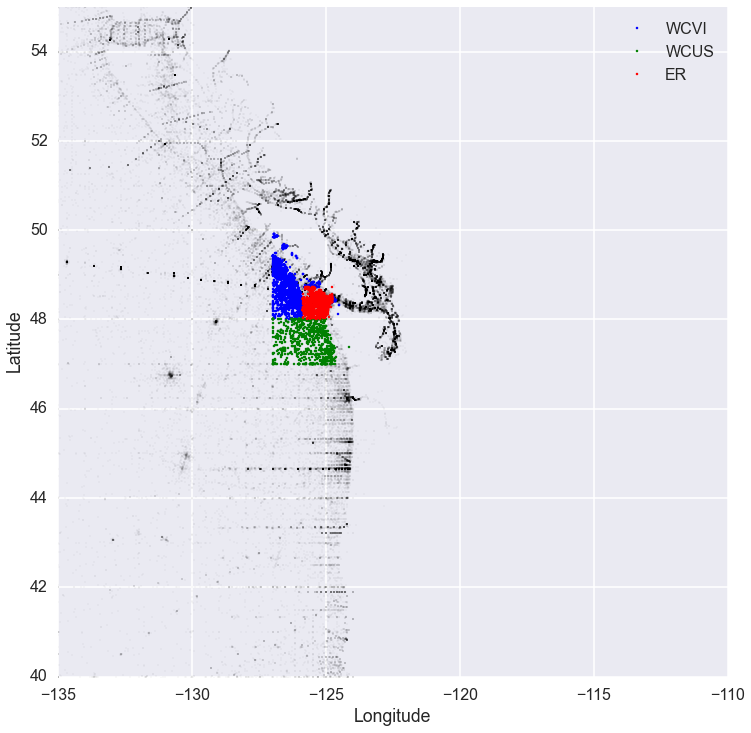

In [32]:
# move the centre down just a touch so region doesn't intersect with VI too much
MB07 = [-(125 + 19.49/60.0),48+28.2/60.0-0.1] 

ERdelx = 0.55
ERdely = 0.35
ER_x = [MB07[0]-ERdelx,MB07[0]+ERdelx,MB07[0]+ERdelx,MB07[0]-ERdelx,MB07[0]-ERdelx]
ER_y = [MB07[1]-ERdely,MB07[1]-ERdely,MB07[1]+ERdely,MB07[1]+ERdely,MB07[1]-ERdely]

WCVI_lnmin = -127
WCVI_lnmax = -124
WCVI_ltmin =  48
WCVI_ltmax =  50

WCUS_lnmin = -127
WCUS_lnmax = -124
WCUS_ltmin =  47
WCUS_ltmax =  48

WCVI_cinf = []
WCUS_cinf = []
ER_cinf = []

WCVI_slope = float(WCVI_ltmin-WCVI_ltmax)/float(WCVI_lnmax-WCVI_lnmin)
WCVI_int   = WCVI_ltmax - WCVI_slope*WCVI_lnmin #y - mx

for cast in cast_inf:
    lt = cast['Latitude']
    ln = cast['Longitude']
    
    # only keep casts with depth info
    if 'Depth' not in cast:
        continue
        
    # only keep deep casts that include points in the range of interest
    if max(cast['Depth']) < 100 or min(cast['Depth']) > 250:
        continue
    
    # ER
    if ln >= min(ER_x) and ln <= max(ER_x) and lt >= min(ER_y) and lt <= max(ER_y):
        ER_cinf.append(cast)
    # WCUS
    elif ln >= WCUS_lnmin and ln <= WCUS_lnmax and lt >= WCUS_ltmin and lt <= WCUS_ltmax:
        WCUS_cinf.append(cast)
    # WCVI
    elif ln >= WCVI_lnmin and  ln <= WCVI_lnmax and \
       lt >= WCVI_ltmin and lt <= WCVI_slope*ln + WCVI_int:
        WCVI_cinf.append(cast)
    
        
ER_lon = [k['Longitude'] for k in ER_cinf]
ER_lat = [k['Latitude'] for k in ER_cinf]

WCVI_lon = [k['Longitude'] for k in WCVI_cinf]
WCVI_lat = [k['Latitude'] for k in WCVI_cinf]

WCUS_lon = [k['Longitude'] for k in WCUS_cinf]
WCUS_lat = [k['Latitude'] for k in WCUS_cinf]

plt.figure(figsize=(12,12))

sns.set_style("darkgrid")
sns.set_context("poster")

#plt.plot(all_filt['ALL']['lons'],all_filt['ALL']['lats'],'.k',ms=2,alpha=0.1)
plt.plot([k['Longitude'] for k in cast_inf],[k['Latitude'] for k in cast_inf],'.k',ms=1,alpha=0.5)
plt.plot(WCVI_lon,WCVI_lat,'.b',ms=5,label='WCVI')
plt.plot(WCUS_lon,WCUS_lat,'.g',ms=5,label='WCUS')
plt.plot(ER_lon,ER_lat,'.r',ms=5,label='ER')
plt.ylim((40,55))
plt.xlim((-135,-110))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [40]:
mnthER_filt = [[] for k in range(1,13)]
mnthWCVI_filt = [[] for k in range(1,13)]
mnthWCUS_filt = [[] for k in range(1,13)]

MIN_YEAR = 1960
MAX_YEAR = 2015

# look at monthly values/percentages/stats for each month
for ii in range(1,13):
    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(ER_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthER_filt[ii-1] = copy.copy(EW_TS)
    mnthER_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthER_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthER_filt[ii-1]['match_perc'] = np.nan
    
    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(WCVI_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthWCVI_filt[ii-1] = copy.copy(EW_TS)
    mnthWCVI_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthWCVI_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthWCVI_filt[ii-1]['match_perc'] = np.nan        

    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(WCUS_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthWCUS_filt[ii-1] = copy.copy(EW_TS)
    mnthWCUS_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthWCUS_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthWCVI_filt[ii-1]['match_perc'] = np.nan        

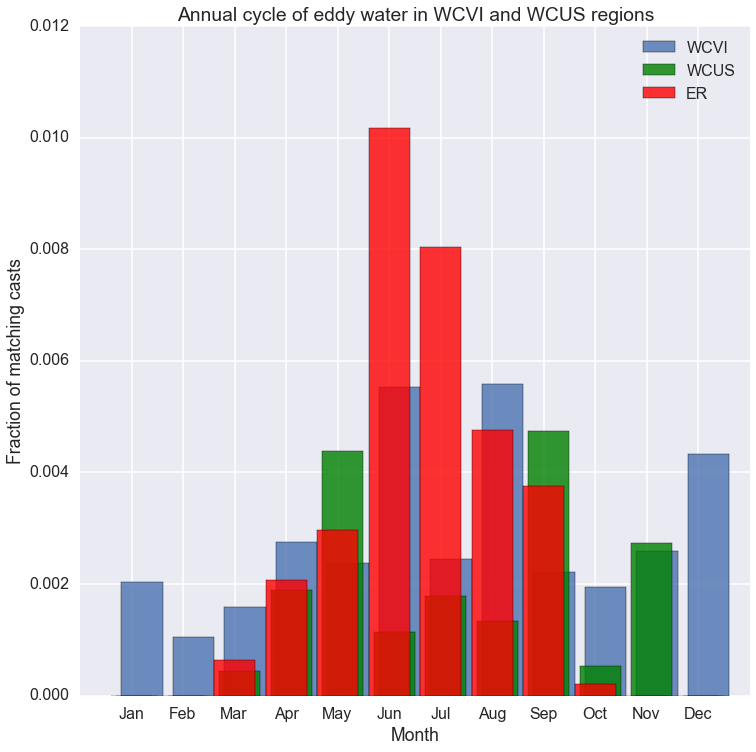

Correlation coefficients for mean EW freq
Corr(WCUS,WCVI)[Jan-Dec] :  -0.0526290964434
Corr(ER,  WCVI)[Mar-Sep] :  0.615650266388
Corr(ER,  WCUS)[Mar-Sep] :  -0.15969619478


In [41]:
plt.figure(figsize=(12,12))

plt.bar(np.arange(1,13)-0.2, [k['match_perc'] for k in mnthWCVI_filt], label='WCVI',alpha=0.8)
plt.bar(np.arange(1,13)-0.3, [k['match_perc'] for k in mnthWCUS_filt], label='WCUS',color='g',alpha=0.8)
plt.bar(np.arange(1,13)-0.4, [k['match_perc'] for k in mnthER_filt], label='ER',alpha=0.8,color='r')

plt.xlim((0,13))
#|plt.ylim((0,.007))

plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.xlabel('Month')
plt.ylabel('Fraction of matching casts')
plt.title('Annual cycle of eddy water in WCVI and WCUS regions')
plt.show()


## ALSO LOOK AT THE CORRELATION BETWEEN CURVES
WCVI_freq = [k['match_perc'] for k in mnthWCVI_filt] 
WCUS_freq = [k['match_perc'] for k in mnthWCUS_filt]
ER_freq = [k['match_perc'] for k in mnthER_filt]

print "Correlation coefficients for mean EW freq"
print "==========================================="
print "Corr(WCUS,WCVI)[Jan-Dec] : ", np.corrcoef(WCUS_freq,WCVI_freq)[1,0]
print "Corr(ER,  WCVI)[Mar-Sep] : ", np.corrcoef(ER_freq[2:9],WCVI_freq[2:9])[1,0]
print "Corr(ER,  WCUS)[Mar-Sep] : ", np.corrcoef(ER_freq[2:9],WCUS_freq[2:9])[1,0]

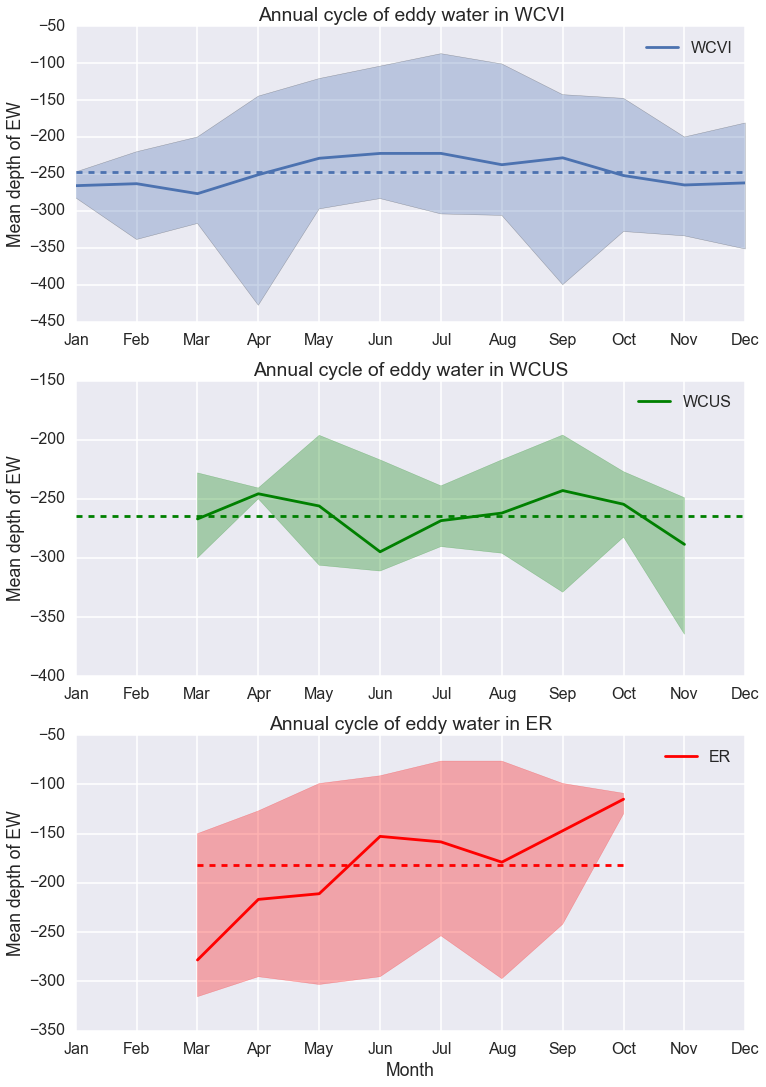

In [42]:
plt.figure(figsize=(12,18))

meanWCVI = np.nanmean([-np.mean(k['dpths']) for k in mnthWCVI_filt])
meanWCUS = np.nanmean([-np.mean(k['dpths']) for k in mnthWCUS_filt])
meanER = np.nanmean([-np.mean(k['dpths']) for k in mnthER_filt])
stdWCVI = np.nanstd([-np.mean(k['dpths']) for k in mnthWCVI_filt])
stdWCUS = np.nanstd([-np.mean(k['dpths']) for k in mnthWCUS_filt])
stdER = np.nanstd([-np.mean(k['dpths']) for k in mnthER_filt])

plt.subplot(3,1,1)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthWCVI_filt], label='WCVI')
plt.gca().set_color_cycle(None)
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthWCVI_filt]-stdWCVI,[-np.mean(k['dpths']) for k in mnthWCVI_filt]+stdWCVI,alpha=0.3)
plt.fill_between(np.arange(1,13),[-np.min(k['dpths']) for k in mnthWCVI_filt],[-np.max(k['dpths']) for k in mnthWCVI_filt],alpha=0.3)
plt.gca().set_color_cycle(None)
plt.plot(np.arange(1,13), [meanWCVI for k in range(1,13)],'--')
plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in WCVI')

plt.subplot(3,1,2)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthWCUS_filt], label='WCUS',color='g')
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthWCUS_filt]-stdWCUS,[-np.mean(k['dpths']) for k in mnthWCUS_filt]+stdWCUS,color='g',alpha=0.3)
plt.fill_between(np.arange(3,12),[-np.min(k['dpths']) for k in mnthWCUS_filt[2:11]],[-np.max(k['dpths']) for k in mnthWCUS_filt[2:11]],color='g',alpha=0.3)
plt.plot(np.arange(1,13), [meanWCUS for k in range(1,13)],'--g')

plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in WCUS')

plt.subplot(3,1,3)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthER_filt], label='ER',color='r')
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthER_filt]-stdER,[-np.mean(k['dpths']) for k in mnthER_filt]+stdER,color='r',alpha=0.3)
plt.fill_between(np.arange(3,11),[-np.min(k['dpths']) for k in mnthER_filt[2:10]],[-np.max(k['dpths']) for k in mnthER_filt[2:10]],color='r',alpha=0.3)
plt.plot(np.arange(3,11), [meanER for k in range(2,10)],'--r')

plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.xlabel('Month')
plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in ER')
plt.show()


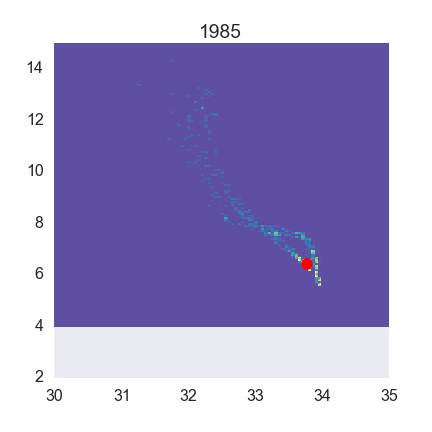
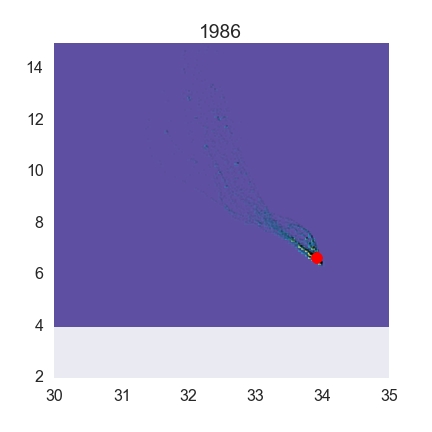
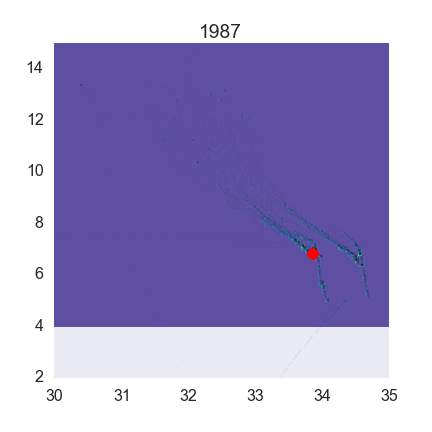
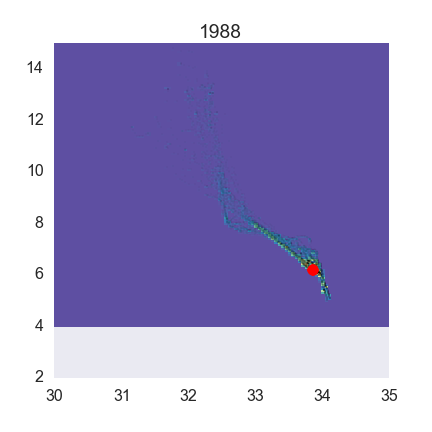
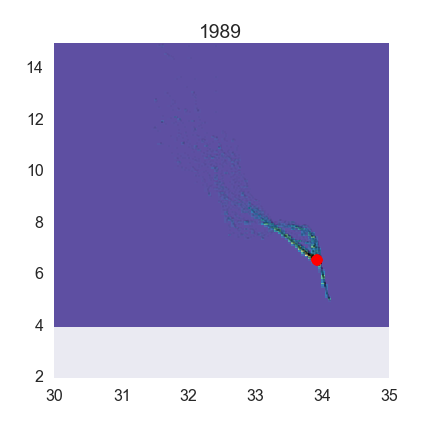
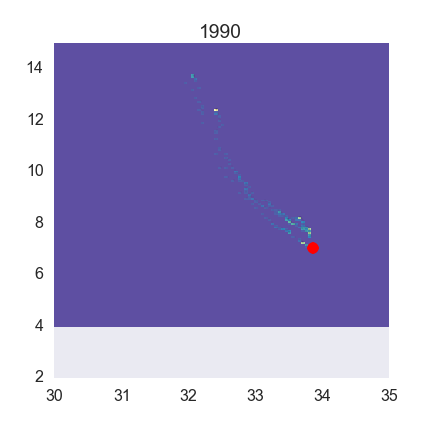
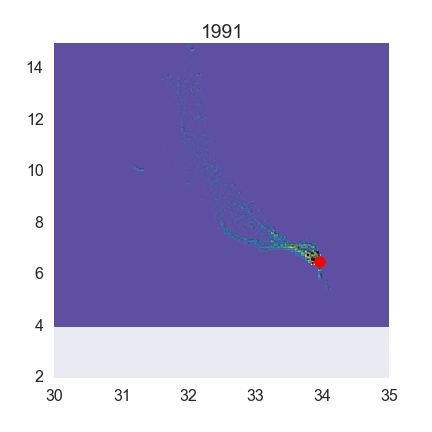
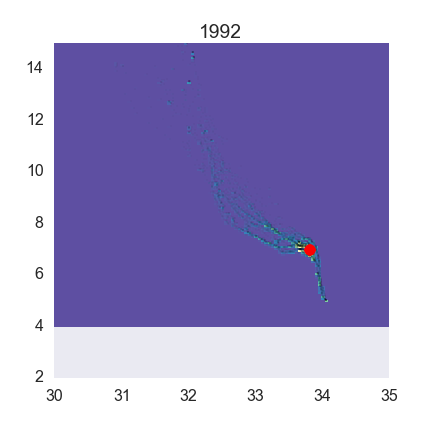
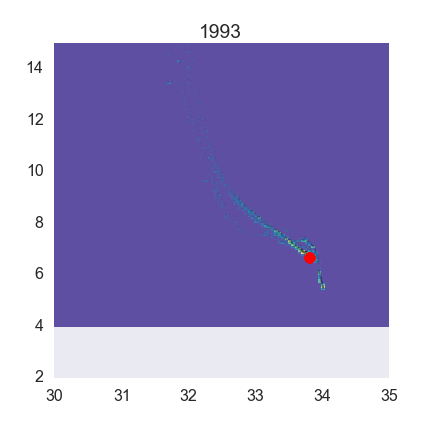
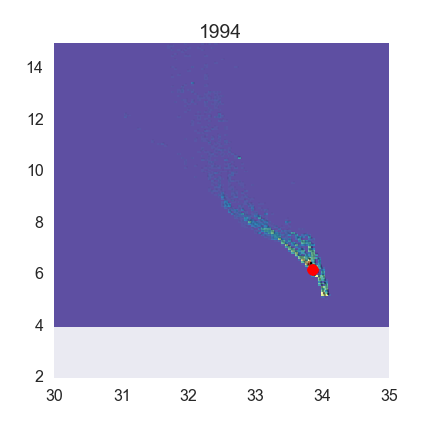
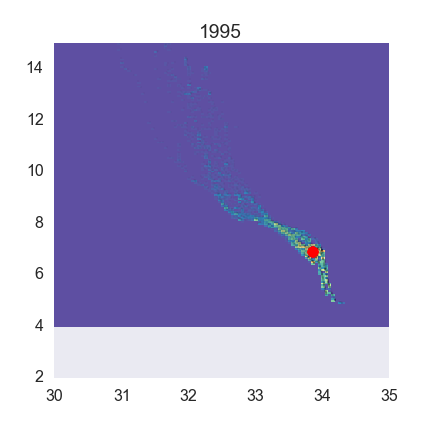
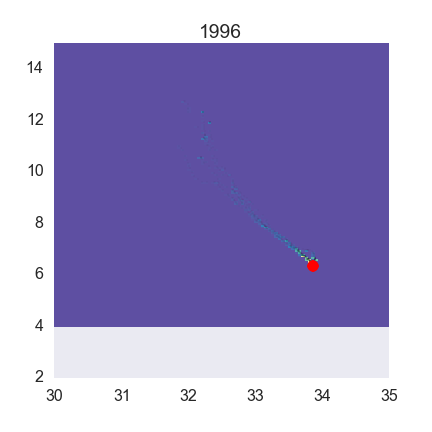
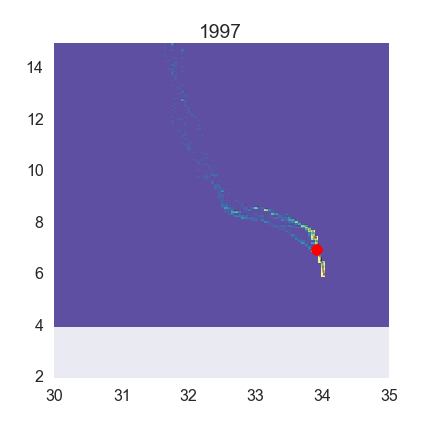
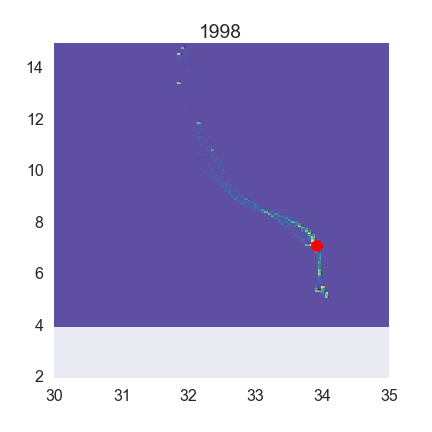
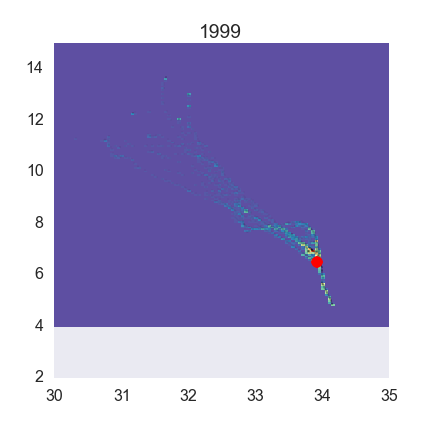
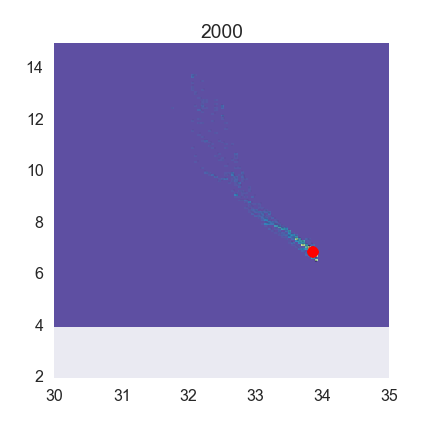
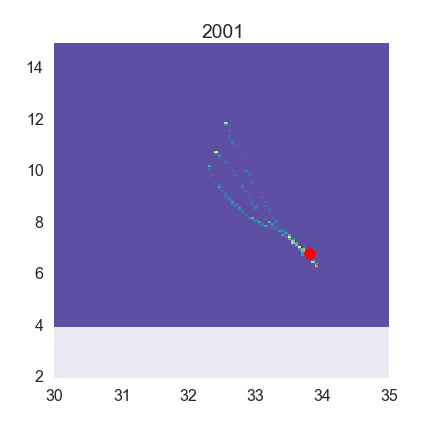
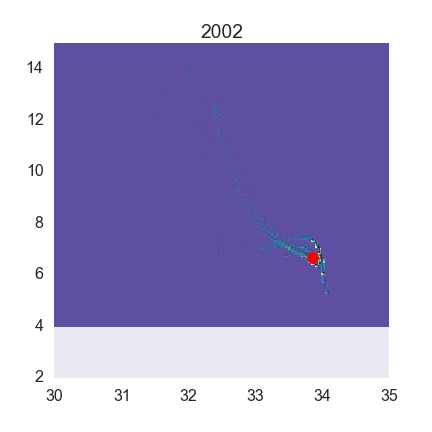
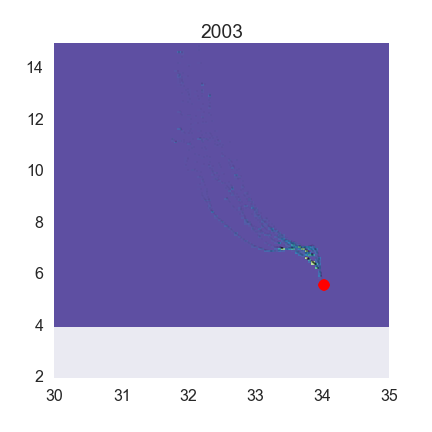
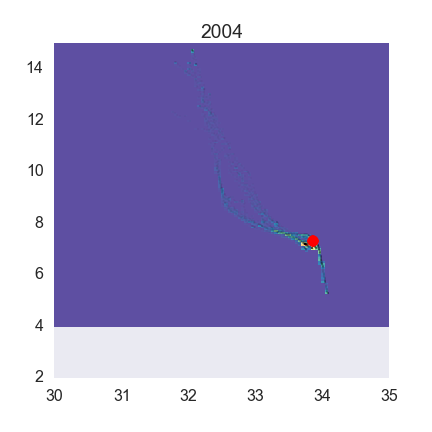
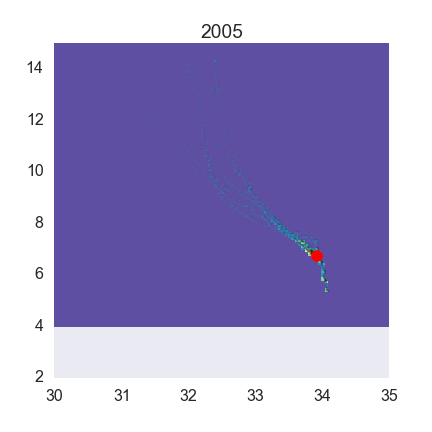

In [89]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(6,6))
ax = plt.axes(xlim=(30,35), ylim=(2,18))
line, = ax.plot([], [], lw=2)

# TAKE IN ER REGION FOR MAY-AUG DATA
#ER_cast_inf = csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_region(cast_inf,min(ER_x),max(ER_x),min(ER_y),max(ER_y)),5,8)

# TAKE IN ER REGION FOR AUG-SEP DATA
ER_cast_inf = csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_region(cast_inf,min(ER_x),max(ER_x),min(ER_y),max(ER_y)),8,9)

MIN_YEAR = 1985
MAX_YEAR = 2005
yrER_cast_inf = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]

# SORT INTO YEARS
for ii in range(MIN_YEAR,MAX_YEAR+1):
    for jj in ER_cast_inf:
        if jj['Year'] == ii and 'Salinity' in jj and 'Temperatur' in jj and len(jj['Depth']) > 1 and max(jj['Depth']) > 100:
            yrER_cast_inf[ii-MIN_YEAR].append(jj)

yearER_T = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]
yearER_S = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]
for ii in range(MIN_YEAR,MAX_YEAR+1):
    yearER_T[ii-MIN_YEAR] = [k['Temperatur'] for k in yrER_cast_inf[ii-MIN_YEAR]]
    yearER_T[ii-MIN_YEAR] = [x for sublist in yearER_T[ii-MIN_YEAR] for x in sublist]
    
    yearER_S[ii-MIN_YEAR] = [k['Salinity'] for k in yrER_cast_inf[ii-MIN_YEAR]]
    yearER_S[ii-MIN_YEAR] = [x for sublist in yearER_S[ii-MIN_YEAR] for x in sublist]

Tbins = np.arange(4,16.1,0.075)
Sbins = np.arange(30,35.1,0.05)

Ty = (Tbins[0:-1]+Tbins[1:])/2
Sx = (Sbins[0:-1]+Sbins[1:])/2

histTS = []

yrEW_T = []
yrEW_S = []

for ii in range(MIN_YEAR,MAX_YEAR+1):
    hist_tmp = np.histogram2d(yearER_S[ii-MIN_YEAR],yearER_T[ii-MIN_YEAR],bins=[Sbins,Tbins])[0]
    IND = np.unravel_index(hist_tmp.argmax(), hist_tmp.shape)
    if hist_tmp[IND[0],IND[1]] > 3:
        yrEW_S.append(Sx[IND[-2]])
        yrEW_T.append(Ty[IND[-1]])
    else:
        yrEW_S.append(np.nan)
        yrEW_T.append(np.nan)
    histTS.append(hist_tmp)
    
def init():
    line.set_data([], [])
    return line,

def animate(i):
    ax.cla()
    ax.plot(yearER_S[i],yearER_T[i],'.k',ms=3,alpha=0.05)
    ax.pcolor(Sbins[:-1],Tbins[:-1],histTS[i].transpose(),cmap='Spectral_r')
    ax.plot(yrEW_S[i],yrEW_T[i],'or')
    ax.set_title(MIN_YEAR+i)
    ax.set_xlim((30,35))
    ax.set_ylim((2,15))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,frames=len(yrER_cast_inf),interval=500)

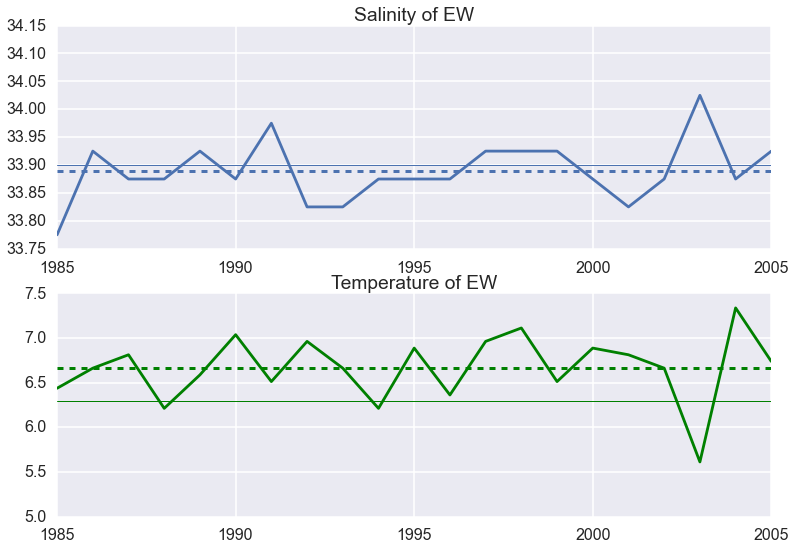

In [90]:
plt.subplot(2,1,1)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yrEW_S)
plt.gca().set_color_cycle(None)
plt.plot([MIN_YEAR,MAX_YEAR],[33.9,33.9],'-',lw=1)
plt.gca().set_color_cycle(None)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[np.mean(yrEW_S) for k in range(MIN_YEAR,MAX_YEAR+1)],'--',lw=3)
plt.ylim((33.75,34.15))
plt.xlim((MIN_YEAR,MAX_YEAR))
plt.title('Salinity of EW')

plt.subplot(2,1,2)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yrEW_T,'g')
plt.plot([MIN_YEAR,MAX_YEAR],[6.3,6.3],'-g',lw=1)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[np.mean(yrEW_T) for k in range(MIN_YEAR,MAX_YEAR+1)],'--g',lw=3)
plt.ylim((5,7.5))
plt.xlim((MIN_YEAR,MAX_YEAR))
plt.title('Temperature of EW')

plt.show()

In [91]:
print 'Corr. coeff. between EW T and EW S: ', np.corrcoef(yrEW_T,yrEW_S)[1,0]

Corr. coeff. between EW T and EW S:  -0.346415949309


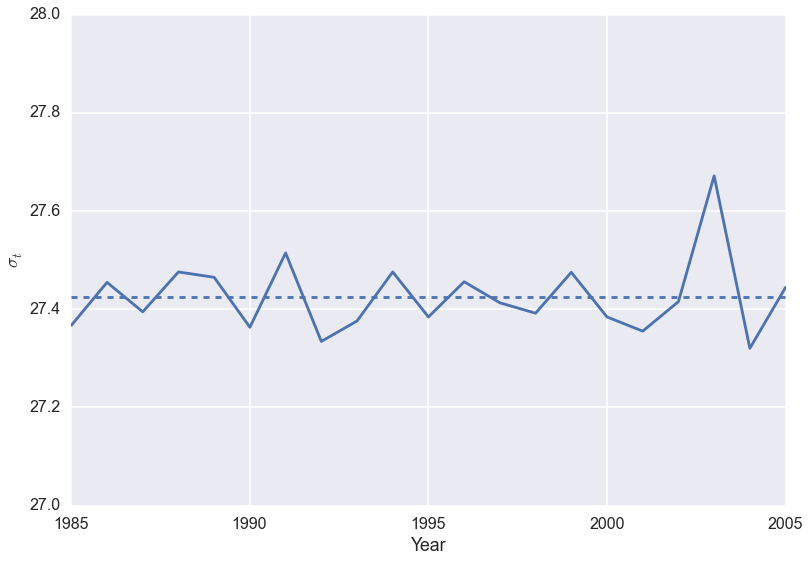

In [92]:
import seawater as SW

sigmaT_EW = []
for ii in range(0,MAX_YEAR-MIN_YEAR+1):
    sigmaT_EW.append(SW.dens(yrEW_S[ii],yrEW_T[ii],-meanER)-1000)

plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),sigmaT_EW)
plt.gca().set_color_cycle(None)
plt.plot([MIN_YEAR,MAX_YEAR],[np.mean(sigmaT_EW),np.mean(sigmaT_EW)],'--')
plt.xlim((MIN_YEAR,MAX_YEAR))
plt.ylim((27,28))

plt.xlabel('Year')
plt.ylabel(r'$\sigma_t$')
plt.show()